In [1]:
import pandas as pd

In [60]:
predictions = pd.read_csv('submission_2019-3-16_18:19.csv')
predictions['Season'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[0]))
predictions['TeamA'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[1]))
predictions['TeamB'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[2]))
predictions = predictions.drop(columns='ID')
predictions['Season'] = pd.to_numeric(predictions['Season'])

In [296]:
slots = pd.read_csv('DataFiles/NCAATourneySlots.csv')
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
seeds['SeedNum'] = seeds['Seed'].str.extract('(\d+)').astype(int)
seasons = pd.read_csv('DataFiles/Seasons.csv',index_col='Season')

In [320]:
season = 2018

bracket = seeds[seeds['Season'] == season].set_index('Seed')['TeamID'].to_dict()

In [421]:
pos = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
get_pos = {k:v for v,k in sorted([(i+1,p) for i,p in zip(range(16),pos)],key=lambda x: x[1])}

next_pos = dict()
for j in range(4):
    A = sum([2**(4-k) for k in range(j)])
    B = sum([2**(4-k) for k in range(j+1)])
    for i in range(2**(4-j)):
        next_pos[i+1+A] = i//2+1+B

In [440]:
for i,game in slots[slots['Season'] == season].iterrows():
    result = dict()
    SS = bracket[game['StrongSeed']]
    WS = bracket[game['WeakSeed']]
    if type(SS) == type(dict()):
        result['Seed'] = SS['Seed']
        if int(game['Slot'][1]) < 5:
            pos = next_pos[SS['Position']]
        else:
            pos = 0
        SS = SS['Team'] 
    else:
        seed = game['StrongSeed'][1:]
        if seed[-1] in ['a','b']:
            seed = seed[:-1]
        pos = get_pos[int(seed)]
        result['Seed'] = seed
    if type(WS) == type(dict()):
        result['Seed'] = WS['Seed']
        if int(game['Slot'][1]) < 5:    
            pos = next_pos[WS['Position']]
        WS = WS['Team']
    else:
        seed = game['WeakSeed'][1:]
        if seed[-1] in ['a','b']:
            seed = seed[:-1]
        else:
            pos = 0
        pos = get_pos[int(seed)]
        result['Seed'] = seed
    result['Position'] = pos
    teamA = min(SS,WS)
    teamB = max(SS,WS)
    pred = predictions[(predictions['TeamA'] == teamA) & (predictions['TeamB'] == teamB) & \
                       (predictions['Season'] == season)]['Pred'].values[0]
    if pred > 0.5:
        result['Team'] = teamA
        result['Prob'] = pred
    else:
        result['Team'] = teamB
        result['Prob'] = 1-pred
    bracket[game['Slot']] = result

In [430]:
def draw_bracket(posX,posY,region,ax,x=6,y=1):
    if posX == 'l':
        xs = 1
        x = -x
    elif posX == 'r':
        xs = -1
    else:
        print('posX not defined')
        return
    
    if posY == 't':
        ys = 1
    elif posY == 'b':
        ys = -1
        y = -y
    else:
        print('posY not defined')
        
    positions = dict()
    for i in range(16):
        ax.plot([x,x+xs],[y+i*ys,y+i*ys],'k')
        positions[i+1] = (x,y+i*ys)
        #ax.text(x+0.5,y+i,str(i+1),ha='center',va='bottom')
        for j in range(4):
            if i%2**(j+1) == 1:
                x0 = x+(j+1)*xs
                y0 = y+(i+2**j-1.5)*ys
                dy = 2**(j-1)
                ax.plot([x0,x0],[y0-dy,y0+dy],'k')
                ax.plot([x0,x0+xs],[y0,y0],'k')
                posNum = sum([2**(4-k) for k in range(j+1)]) + i//(2**(j+1)) + 1
                positions[posNum] = (x0,y0)
                #ax.text(x0+0.5,y0,str(posNum),ha='center',va='bottom')
    
    ax.text(x+2*xs,y+18*ys,region,ha='center',va='center',size=20)
    
    return positions

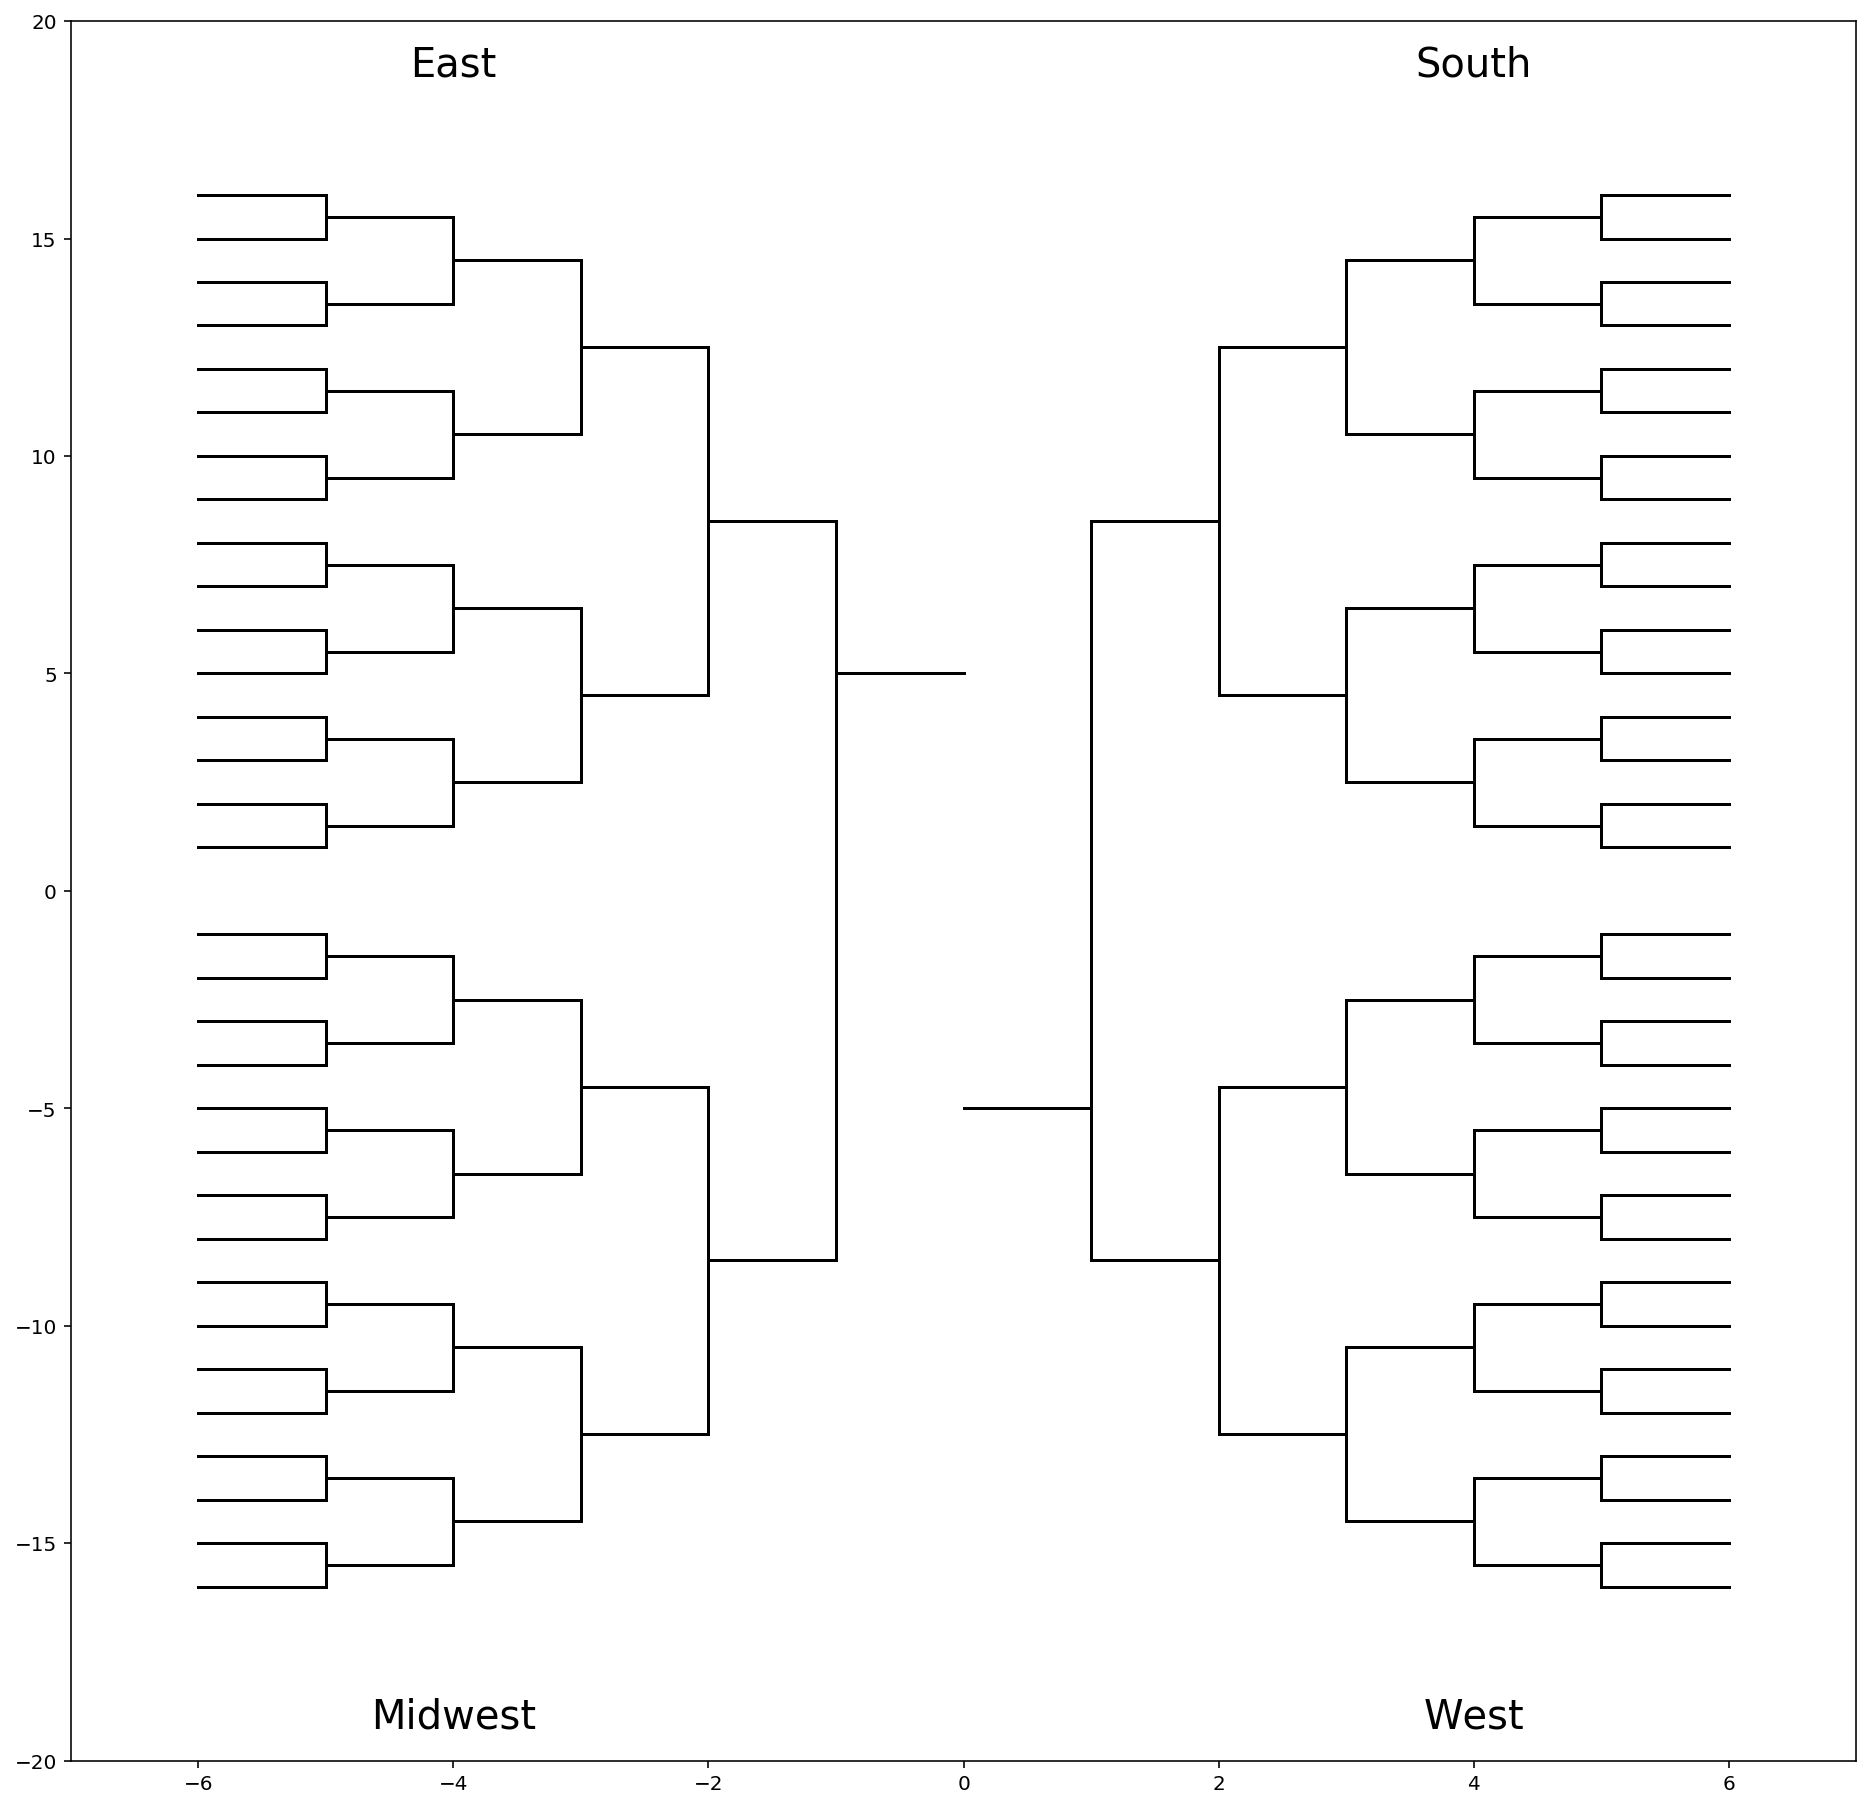

In [434]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(16,16))
ax.set_xlim(-7,7)
ax.set_ylim(-20,20)

TL = draw_bracket('l','t',seasons.loc[season,'RegionW'],ax)
LB = draw_bracket('l','b',seasons.loc[season,'RegionX'],ax)
RT = draw_bracket('r','t',seasons.loc[season,'RegionY'],ax)
RB = draw_bracket('r','b',seasons.loc[season,'RegionZ'],ax)

ax.plot([-1,-1],[-8.5,8.5],'k')
ax.plot([1,1],[-8.5,8.5],'k')

ax.plot([-1,0],[5,5],'k')
ax.plot([0,1],[-5,-5],'k')
plt.show()

In [435]:
TL

{1: (-6, 1),
 2: (-6, 2),
 17: (-5, 1.5),
 25: (-4, 2.5),
 29: (-3, 4.5),
 31: (-2, 8.5),
 3: (-6, 3),
 4: (-6, 4),
 18: (-5, 3.5),
 5: (-6, 5),
 6: (-6, 6),
 19: (-5, 5.5),
 26: (-4, 6.5),
 7: (-6, 7),
 8: (-6, 8),
 20: (-5, 7.5),
 9: (-6, 9),
 10: (-6, 10),
 21: (-5, 9.5),
 27: (-4, 10.5),
 30: (-3, 12.5),
 11: (-6, 11),
 12: (-6, 12),
 22: (-5, 11.5),
 13: (-6, 13),
 14: (-6, 14),
 23: (-5, 13.5),
 28: (-4, 14.5),
 15: (-6, 15),
 16: (-6, 16),
 24: (-5, 15.5)}

In [436]:
slots.head()

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12
